In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error,SCORERS
from sklearn.model_selection import cross_val_score

# Models
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm 
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

import xgboost as xgb


#To export the model
import pickle


!ls

__notebook__.ipynb


In [2]:
np.random.seed(30)

In [3]:
df = pd.read_csv('/kaggle/input/nyc-rolling-data.csv')

In [4]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,376,43,NaN,S1,743 EAST 6TH STREET,NaN,...,1.0,1.0,2.0,2090.0,3680.0,1940.0,1,S1,3200000,2019-07-24 00:00:00
1,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,390,61,NaN,A4,189 EAST 7TH STREET,NaN,...,1.0,0.0,1.0,987.0,2183.0,1860.0,1,A4,0,2019-09-25 00:00:00
2,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,404,1,NaN,B9,166 AVENUE A,NaN,...,2.0,0.0,2.0,1510.0,4520.0,1900.0,1,B9,0,2019-07-22 00:00:00
3,1,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,377,56,NaN,C0,263 EAST 7TH STREET,NaN,...,3.0,0.0,3.0,2430.0,3600.0,1899.0,1,C0,6300000,2019-04-30 00:00:00
4,1,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,393,9,NaN,C0,604 EAST 11TH STREET,NaN,...,3.0,0.0,3.0,2375.0,5110.0,1939.0,1,C0,0,2019-10-24 00:00:00


In [5]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object')

# Data Cleaning/Validation

In [6]:
# change building class to type int
df['BUILDING CLASS CATEGORY']=df['BUILDING CLASS CATEGORY'].str[0:2]
df['BUILDING CLASS CATEGORY']=df['BUILDING CLASS CATEGORY'].astype(int)

#drop easement 100% Nan ,Apartment Number 70% Nan and Address is too specific probably wont generalize
df.drop(columns=['EASE-MENT','APARTMENT NUMBER','ADDRESS'], inplace=True)

# Drop properties that were transfered without cash consideration
df=df[df['SALE PRICE']!=0]

# Deal with NaN
df.fillna(-1,inplace=True)

In [7]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,1,1,376,43,S1,10009.0,1.0,1.0,2.0,2090.0,3680.0,1940.0,1,S1,3200000,2019-07-24 00:00:00
3,1,ALPHABET CITY,3,1,377,56,C0,10009.0,3.0,0.0,3.0,2430.0,3600.0,1899.0,1,C0,6300000,2019-04-30 00:00:00
5,1,ALPHABET CITY,7,2,372,23,C1,10009.0,12.0,0.0,12.0,2393.0,7989.0,2001.0,2,C1,1950000,2019-08-08 00:00:00
7,1,ALPHABET CITY,7,2A,376,23,C3,10009.0,4.0,0.0,4.0,2059.0,4154.0,1900.0,2,C3,600000,2019-12-12 00:00:00
8,1,ALPHABET CITY,7,2A,376,26,C3,10009.0,4.0,0.0,4.0,2065.0,3491.0,1900.0,2,C3,4350000,2019-10-31 00:00:00


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56741 entries, 0 to 81482
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         56741 non-null  int64  
 1   NEIGHBORHOOD                    56741 non-null  object 
 2   BUILDING CLASS CATEGORY         56741 non-null  int64  
 3   TAX CLASS AT PRESENT            56741 non-null  object 
 4   BLOCK                           56741 non-null  int64  
 5   LOT                             56741 non-null  int64  
 6   BUILDING CLASS AT PRESENT       56741 non-null  object 
 7   ZIP CODE                        56741 non-null  float64
 8   RESIDENTIAL UNITS               56741 non-null  float64
 9   COMMERCIAL UNITS                56741 non-null  float64
 10  TOTAL UNITS                     56741 non-null  float64
 11  LAND SQUARE FEET                56741 non-null  float64
 12  GROSS SQUARE FEET               

# Random Forrest Regressor

## Baseline

In [9]:
X_train ,X_test, y_train, y_test = train_test_split(df.drop(columns=['SALE PRICE','SALE DATE','NEIGHBORHOOD','TAX CLASS AT PRESENT','BUILDING CLASS AT PRESENT','BUILDING CLASS AT TIME OF SALE']),df['SALE PRICE'],test_size=0.2)

In [10]:
model_rf = RandomForestRegressor(random_state=0,n_jobs=4)
model_rf.fit(X_train,y_train)
predicted = model_rf.predict(X_test)
mean_absolute_error(y_test,predicted)

1173457.246346882

Feature ranking:
1. feature 2 (0.281490)
2. feature 9 (0.201380)
3. feature 3 (0.110341)
4. feature 4 (0.100834)
5. feature 8 (0.087557)
6. feature 10 (0.069185)
7. feature 6 (0.042251)
8. feature 7 (0.041844)
9. feature 1 (0.040229)
10. feature 0 (0.009720)
11. feature 11 (0.008345)
12. feature 5 (0.006823)


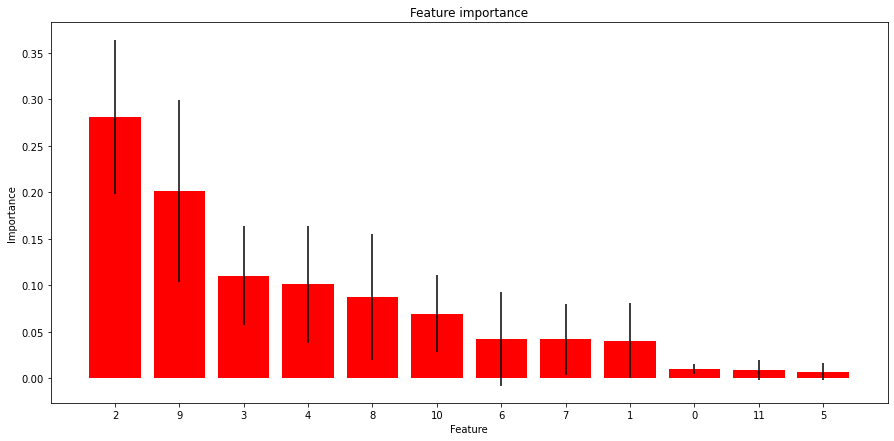

<Figure size 432x288 with 0 Axes>

In [11]:
#Plotting feature importance of the numeric features
importances = model_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(15,7))
plt.title("Feature importance")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()
plt.savefig('NumericalFeatures.png')

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45392 entries, 32799 to 55392
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BOROUGH                    45392 non-null  int64  
 1   BUILDING CLASS CATEGORY    45392 non-null  int64  
 2   BLOCK                      45392 non-null  int64  
 3   LOT                        45392 non-null  int64  
 4   ZIP CODE                   45392 non-null  float64
 5   RESIDENTIAL UNITS          45392 non-null  float64
 6   COMMERCIAL UNITS           45392 non-null  float64
 7   TOTAL UNITS                45392 non-null  float64
 8   LAND SQUARE FEET           45392 non-null  float64
 9   GROSS SQUARE FEET          45392 non-null  float64
 10  YEAR BUILT                 45392 non-null  float64
 11  TAX CLASS AT TIME OF SALE  45392 non-null  int64  
dtypes: float64(7), int64(5)
memory usage: 4.5 MB


|Feature ranking|Feature number|Feature name| 
|--------------|--------------|------------| 
|1             |2             |Block       | 
|2             |9             |Gross square feet|
|3             |3             |Lot         | 
|4             |4             |Zipcode     |
|5             |8             |Land square feet|
|6             |10            |Year built|
|7             |6             |Commerical units|
|8             |7             |Total units|
|9             |1             |Building Class Category|
|10            |0             |Borough|
|11            |11            |Tax class at time of sale|
|12            |5             |Residential units|  



In [13]:
model_rf = RandomForestRegressor(random_state=0,n_jobs=4)
model_rf.fit(X_train,y_train)
predicted = model_rf.predict(X_test)
mean_absolute_error(y_test,predicted)

1173457.246346882

## Try by dropping categorical values

In [14]:

one_hot =['NEIGHBORHOOD','TAX CLASS AT PRESENT','BUILDING CLASS AT PRESENT','BUILDING CLASS AT TIME OF SALE']
df=pd.get_dummies(df,columns=one_hot)

In [15]:
X_train ,X_test, y_train, y_test = train_test_split(df.drop(columns=['SALE PRICE','SALE DATE']),df['SALE PRICE'],test_size=0.2)

In [16]:
model_rf = RandomForestRegressor(random_state=0,n_jobs=4)
model_rf.fit(X_train,y_train)
predicted = model_rf.predict(X_test)
mean_absolute_error(y_test,predicted)

1071918.1277471606

In [17]:
# 1.07 million

# Using cross validation

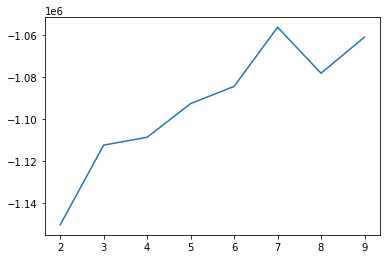

In [18]:
 
model_rf = RandomForestRegressor(random_state=0,n_jobs=4)
#model_rf.fit(X_train,y_train)
#predicted = model_rf.predict(X_train)
#mean_absolute_error(y_train,predicted)
error=[]
split=[]
for cv in range(2,10):
    split.append(cv)
    error.append(np.mean(cross_val_score(model_rf,X_train,y_train,cv=cv,scoring='neg_mean_absolute_error')))
plt.plot(split,error)

### Best cv at 7 folds gives roughly the same mae as the regular model

# Ordinary least squares

In [19]:
x_sm = sm.add_constant(X_train)
model = sm.OLS(y_train,x_sm)
model.fit().summary()

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SALE PRICE   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     23.28
Date:                Tue, 02 Jun 2020   Prob (F-statistic):               0.00
Time:                        02:27:42   Log-Likelihood:            -8.1374e+05
No. Observations:               45392   AIC:                         1.628e+06
Df Residuals:                   44908   BIC:                         1.633e+06
Df Model:                         483                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                   1.017e+07   1.09e+07      0.931      0.352   -1.12e+07    3.16e+07
BOROUGH                                -1.235e+06   3.13e+06     -0.395      0.693   -7.37e+06     4.9e+06
BUILDING CLASS CATEGORY                 -2.29e+05   4.82e+05     -0.475      0.635   -1.17e+06    7.15e+05
BLOCK                                   -164.1211    160.966     -1.020      0.308    -479.617     151.375
LOT                                       78.5377    210.649      0.373      0.709    -334.338     491.414
ZIP CODE                                -126.2951    450.614     -0.280      0.779   -1009.506     756.916
RESIDENTIAL UNITS                      -3.328e+05   4.63e+06     -0.072      0.943   -9.41e+06    8.74e+06
COMMERCIAL UNITS                        -6.71e+05   4.63e+06     -0.145      0.885   -9.74e+06     8.4e+06
TOTAL UNITS                              7.09e+05   4.63e+06      0.153      0.878   -8.36e+06    9.78e+06
LAND SQUARE FEET                          -0.3818      0.769     -0.497      0.620      -1.889       1.125
GROSS SQUARE FEET                         -1.3202      3.871     -0.341      0.733      -8.908       6.268
YEAR BUILT                             -1653.2419    181.860     -9.091      0.000   -2009.692   -1296.792
TAX CLASS AT TIME OF SALE               1.231e+06   5.49e+06      0.224      0.822   -9.53e+06     1.2e+07
NEIGHBORHOOD_AIRPORT LA GUARDIA        -4.318e+04   7.83e+06     -0.006      0.996   -1.54e+07    1.53e+07
NEIGHBORHOOD_ALPHABET CITY             -3.522e+06   7.18e+06     -0.490      0.624   -1.76e+07    1.06e+07
NEIGHBORHOOD_ANNADALE                   1.407e+06   5.75e+06      0.245      0.807   -9.87e+06    1.27e+07
NEIGHBORHOOD_ARDEN HEIGHTS              1.619e+06   5.67e+06      0.286      0.775   -9.49e+06    1.27e+07
NEIGHBORHOOD_ARROCHAR                   1.888e+06   6.76e+06      0.279      0.780   -1.14e+07    1.51e+07
NEIGHBORHOOD_ARROCHAR-SHORE ACRES       1.521e+06   6.61e+06      0.230      0.818   -1.14e+07    1.45e+07
NEIGHBORHOOD_ARVERNE                    2.895e+06   3.35e+06      0.865      0.387   -3.67e+06    9.46e+06
NEIGHBORHOOD_ASTORIA                    4.014e+05   2.64e+06      0.152      0.879   -4.78e+06    5.58e+06
NEIGHBORHOOD_BATH BEACH                -2.812e+05    1.4e+06     -0.200      0.841   -3.03e+06    2.47e+06
NEIGHBORHOOD_BATHGATE                   -3.83e+06   4.44e+06     -0.864      0.388   -1.25e+07    4.86e+06
NEIGHBORHOOD_BAY RIDGE                  -3.68e+04   1.02e+06     -0.036      0.971   -2.04e+06    1.97e+06
NEIGHBORHOOD_BAYCHESTER                -2.673e+06   3.94e+06     -0.678      0.498   -1.04e+07    5.05e+06
NEIGHBORHOOD_BAYSIDE                    1.178e+06   2.59e+06      0.455      0.649   -3

### Model explains aorund 20% of the variation which is poor

# Linear regressor

## Baseline

In [20]:
model_lr= LinearRegression(n_jobs=4)
model_lr.fit(X_train, y_train)
prediction = model_lr.predict(X_test)
mean_absolute_error(y_test,prediction)


16938777031.514257

### MAE of 16.94 billion

In [21]:
## Cross Validation

In [22]:
model_lr= LinearRegression(n_jobs=4)
np.mean(cross_val_score(model_lr,X_train,y_train,cv=4,scoring='neg_mean_absolute_error'))

-5466693051.091256

### MAE of 5.47 billion

# Lasso Regressor

## Baseline

In [23]:
model_lasso=Lasso()
model_lasso.fit(X_train, y_train)
prediction = model_lasso.predict(X_test)
mean_absolute_error(y_test,prediction)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.950057658946346e+18, tolerance: 1237846316509457.8
  positive)


2657623.143976724

## Cross validation

In [24]:
model_lasso=Lasso()
model_lasso.fit(X_train, y_train)
prediction = model_lasso.predict(X_test)
np.mean(cross_val_score(model_lasso,X_train,y_train,cv=7,scoring='neg_mean_absolute_error'))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.950057658946346e+18, tolerance: 1237846316509457.8
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.5469591991829755e+18, tolerance: 1118355090757095.9
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.698141783214778e+18, tolerance: 1159307897261520.5
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

-2482515.601340419

## Cross validation while changing alpha

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.642454859660063e+18, tolerance: 474882015285921.0
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.874876144827525e+18, tolerance: 946573305262198.2
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.277836145431317e+18, tolerance: 1054195765746227.6
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

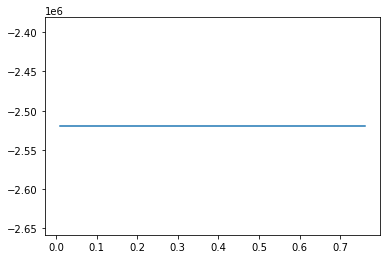

In [25]:
model_lasso=Lasso()
alpha=[]
error =[]

for i in range(1,100, 25):
    alpha.append(i/100)
    model_las=Lasso(alpha=(i/100))
    error.append(np.mean(cross_val_score(model_lasso,X_train,y_train,cv=3,scoring='neg_mean_absolute_error')))
plt.plot(alpha,error)

In [26]:
### Alpha doesnt affect mean cross validation socre, perhaps the model is not the right choice

# Ridge Regressor

## Baseline

In [27]:

model_rdg = Ridge(alpha=1, normalize=True)
model_rdg.fit(X_train, y_train)
prediction = model_rdg.predict(X_test)
mean_absolute_error(y_test,prediction)

2132797.739501358

## Cross validation

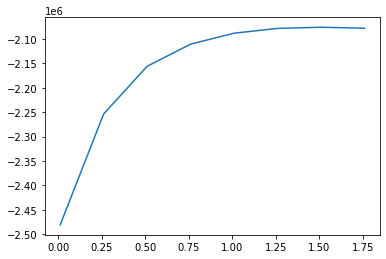

In [28]:
error=[]
alpha=[]

for i in range(1,200,25):
    model_rdg = Ridge(alpha=(i/100), normalize=True)
    alpha.append(i/100)
    error.append(np.mean(cross_val_score(model_rdg,X_train,y_train,cv=4,scoring='neg_mean_absolute_error')))
plt.plot(alpha,error)

# XGBoost

## Baseline

In [29]:
model_xgb = XGBRegressor(n_jobs=4)
model_xgb.fit(X_train, y_train)
prediction = model_xgb.predict(X_test)
mean_absolute_error(y_test,prediction)

1239963.6686954282

## Tuning

### Learning Rate

[0]	validation_0-rmse:14949263.00000
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:14892498.00000
[2]	validation_0-rmse:14836770.00000
[3]	validation_0-rmse:14782033.00000
[4]	validation_0-rmse:14728309.00000
[5]	validation_0-rmse:14675593.00000
[6]	validation_0-rmse:14623824.00000
[7]	validation_0-rmse:14572977.00000
[8]	validation_0-rmse:14520808.00000
[9]	validation_0-rmse:14471876.00000
[10]	validation_0-rmse:14421534.00000
[11]	validation_0-rmse:14372151.00000
[12]	validation_0-rmse:14324889.00000
[13]	validation_0-rmse:14279521.00000
[14]	validation_0-rmse:14232831.00000
[15]	validation_0-rmse:14186930.00000
[16]	validation_0-rmse:14143314.00000
[17]	validation_0-rmse:14101429.00000
[18]	validation_0-rmse:14058269.00000
[19]	validation_0-rmse:14017948.00000
[20]	validation_0-rmse:13976173.00000
[21]	validation_0-rmse:13936390.00000
[22]	validation_0-rmse:13896773.00000
[23]	validation_0-rmse:13859324.00000
[24]	validation_0-rmse:13820930.00

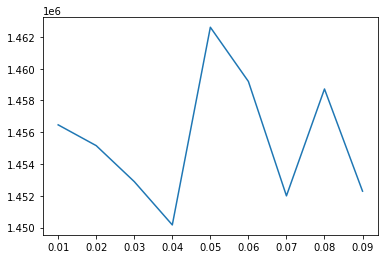

In [30]:
error = []
lr=[]
for x in range(1,10):
    
    model_xgb = XGBRegressor(n_jobs=4,learning_rate=(x/100))
    model_xgb.fit(X_train, y_train, 
                  early_stopping_rounds=5,
                 eval_set=[(X_test, y_test)],
                 verbose=True)
    prediction =model_xgb.predict(X_test)
    lr.append(x/100)
    error.append(mean_absolute_error(y_test,prediction))
plt.plot(lr,error)

### Rounds

In [31]:

model_xgb = XGBRegressor(n_estimators=1000,n_jobs=4,learning_rate=0.04)
model_xgb.fit(X_train, y_train, 
              eval_set=[(X_test, y_test)],
               verbose=False)
prediction =model_xgb.predict(X_test)
mean_absolute_error(y_test,prediction)

1234705.5237392285

In [32]:
# save best model to pickle

In [33]:
pickl = {'model': model_rf}
pickle.dump( pickl, open( 'model_file' + ".p", "wb" ) )